## Import necessary libraries

In [1]:
import os
import random
import pandas as pd
from tqdm import tqdm
from collections import Counter, defaultdict

import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from spacy.util import minibatch, compounding
from sklearn.model_selection import train_test_split

from training_constants import *
from read_dataset import *
from visualization import visualize_labels

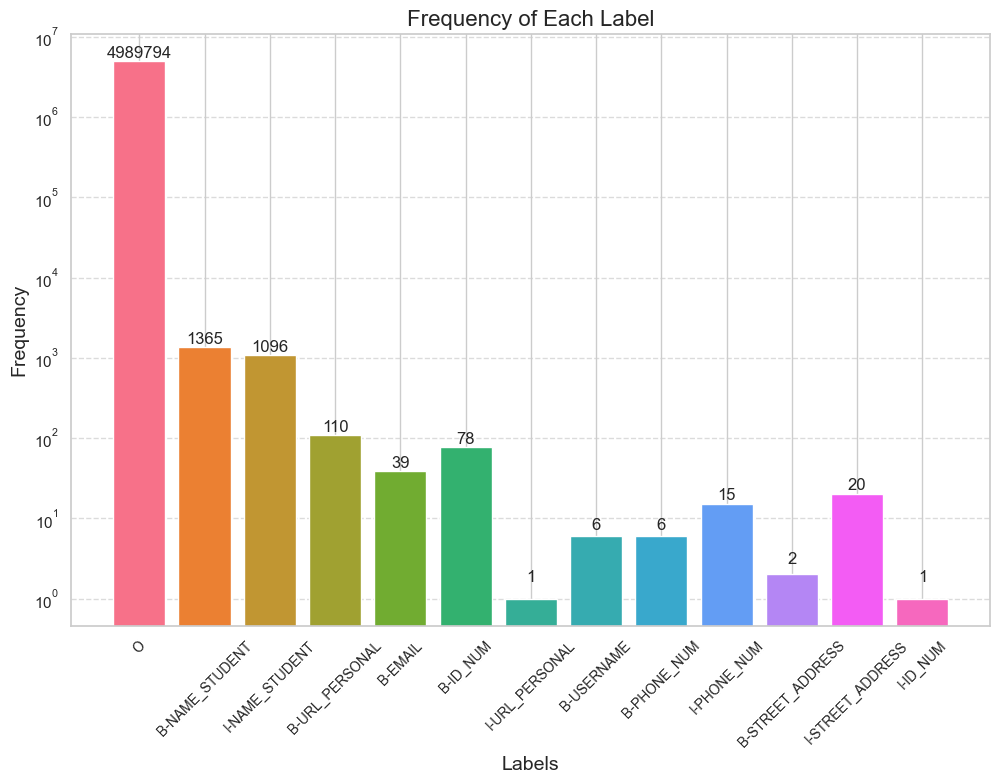

In [2]:
# Download training set from S3 if not available locally
if not os.path.exists(f"{DATASETS_DIRECTORY}/{INITIAL_TRAIN_SET}"):
    print("Training set not found! Downloading from AWS S3")
    download_file_from_s3(S3_BUCKET_NAME, INITIAL_TRAIN_SET, f"{DATASETS_DIRECTORY}/{INITIAL_TRAIN_SET}")

# Parse the training dataset for relevant fields
document_numbers, texts, tokens, trailing_whitespaces, labels = read_pii_json(f"{DATASETS_DIRECTORY}/{INITIAL_TRAIN_SET}", is_train=True)

# Zip the data together
zipped_data = list(zip(document_numbers, texts, tokens, trailing_whitespaces, labels))

# Perform the train-test split
train_data, test_data = train_test_split(zipped_data, test_size=0.30, random_state=0)

# Unzip the training and testing data
document_numbers_train, texts_train, tokens_train, trailing_whitespaces_train, labels_train = zip(*train_data)
document_numbers_test, texts_test, tokens_test, trailing_whitespaces_test, labels_test = zip(*test_data)

# Flatten labels list for plotting
flat_labels = [label for sublist in labels for label in sublist]
unique_labels = set(flat_labels)

# Count the label frequencies
label_counts = Counter(flat_labels)

# Prepare data for plotting
labels, frequencies = zip(*label_counts.items())

visualize_labels(labels, frequencies)

In [3]:
def prepare_documents(nlp, texts, tokens, labels):
    # Initialize DocBin to store the training examples
    doc_bin = DocBin()

    annotated_data = []

    # Wrap the main loop with tqdm for progress visualization
    for text, doc_tokens, doc_labels in tqdm(zip(texts, tokens, labels), total=len(texts), desc="Processing Documents"):
        doc = nlp.make_doc(text)
        ents = []
        position = 0
        
        for token, label in zip(doc_tokens, doc_labels):
            if label != "O":
                start_actual = text.find(token, position)
                end_actual = start_actual + len(token)

                # Catch instances when substring is not found from the text
                if start_actual == -1:
                    raise ValueError(f"Token '{token}' not found from the text[{position}]!") 
                ents.append((start_actual, end_actual, label))

                position = end_actual

        annotated_data.append((text, {"entities": ents}))
        # Append the example to DocBin
        example = Example.from_dict(doc, {"entities": ents})
        doc_bin.add(example.reference)

    return doc_bin, annotated_data

In [4]:
def fbeta_score(precision, recall, beta=5):
    if precision == 0.0 or recall == 0.0:
        return 0.0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

## Split the dataset into training and test sets

In [5]:
# # Zip the data together
# zipped_data = list(zip(document_numbers, texts, tokens, trailing_whitespaces, labels))

# # Perform the train-test split
# train_data, test_data = train_test_split(zipped_data, test_size=0.30, random_state=0)

# # Unzip the training and testing data
# document_numbers_train, texts_train, tokens_train, trailing_whitespaces_train, labels_train = zip(*train_data)
# document_numbers_test, texts_test, tokens_test, trailing_whitespaces_test, labels_test = zip(*test_data)

## Initialization of a blank SpaCy NER model

In [6]:
# Load a blank Spacy model
nlp = spacy.blank("en")

# Create a new entity recognizer and add it to the pipeline if it's not already present
if "ner" not in nlp.pipe_names:
    ner = nlp.add_pipe("ner")
else:
    ner = nlp.get_pipe("ner")

c:\Users\lendl\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\Users\lendl\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## Creation of documents to be used as inputs to the model

In [7]:
doc_bin_train, annotated_data = prepare_documents(nlp, texts_train, tokens_train, labels_train)

# Save the data from DocBin
doc_bin_train.to_disk("./models/spacy/train.spacy")

Processing Documents: 100%|██████████| 4764/4764 [00:14<00:00, 336.45it/s]


In [8]:
# Load the serialized data from DocBin
doc_bin_train = DocBin().from_disk("./models/spacy/train.spacy")
train_data = list(doc_bin_train.get_docs(nlp.vocab))  # This will create a list of Doc objects

# Create Example objects required for training
examples = []
for doc in tqdm(train_data, desc="Processing Training Documents"):
    examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))

# Add labels to the NER
for example in tqdm(examples, desc="Adding Labels"):
    for ent in example.reference.ents:
        ner.add_label(ent.label_)

Adding Labels: 100%|██████████| 4764/4764 [00:00<00:00, 144848.20it/s]


## Train the model on the tokenized training set

In [9]:
# Train the NER model
# Reference for loss computation: https://github.com/explosion/spaCy/discussions/9128
optimizer = nlp.begin_training()
batch_sizes = compounding(8.0, 64.0, 1.001)  # Dynamically change batch size from 8 to 64

batch_sizes = compounding(8.0, 64.0, 1.001)  # Dynamically change batch size from 8 to 64
for i in tqdm(range(5), desc="Training Model"):
    losses = {}
    random.shuffle(examples)  # Shuffle the training data before each iteration
    batches = minibatch(examples, size=batch_sizes)  # Create minibatches
    for batch in batches:
        nlp.update(batch, drop=0.3, losses=losses)
    print(f"Losses at iteration {i}: {losses}")

Training Model:  20%|██        | 1/5 [03:48<15:13, 228.41s/it]

Losses at iteration 0: {'ner': 46704.49121232342}


Training Model:  40%|████      | 2/5 [07:33<11:18, 226.21s/it]

Losses at iteration 1: {'ner': 1525.9634122810262}


Training Model:  60%|██████    | 3/5 [11:13<07:26, 223.49s/it]

Losses at iteration 2: {'ner': 1004.8037993347857}


Training Model:  80%|████████  | 4/5 [14:52<03:41, 221.66s/it]

Losses at iteration 3: {'ner': 728.6141404789048}


Training Model: 100%|██████████| 5/5 [18:29<00:00, 221.95s/it]

Losses at iteration 4: {'ner': 541.9510576885069}


In [10]:
# Save the model
nlp.to_disk("./models/spacy/pii_ner_blank_spacy")

## Perform model inference on the test set

In [11]:
# Initialize DocBin to store the training examples
doc_bin_test, annotated_test_data = prepare_documents(nlp, texts_test, tokens_test, labels_test)

# Save the data from DocBin
doc_bin_test.to_disk("./models/spacy/test.spacy")

Processing Documents: 100%|██████████| 2043/2043 [00:05<00:00, 370.78it/s]


In [12]:
# Load the serialized test data from DocBin
doc_bin_test = DocBin().from_disk("./models/spacy/test.spacy")
test_data = list(doc_bin_test.get_docs(nlp.vocab))

# Create Example objects for the test set
test_examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in test_data]

# Load your trained model
nlp = spacy.load("./models/spacy/pii_ner_blank_spacy")

# After training, evaluate on the test set
scorer = nlp.evaluate(test_examples)
precision = scorer["ents_p"]
recall = scorer["ents_r"]
f5_score = fbeta_score(precision, recall, beta=5)

print("Evaluation Metrics:")
print(f"F5-Score: {f5_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Evaluation Metrics:
F5-Score: 0.9977584506410831
Precision: 0.9448123620309051
Recall: 1.0


### Save predictions in a csv file with a similar format as the Kaggle competiton requirement

In [13]:
# Prepare to collect all the rows for the DataFrame
rows = []

# Iterate over each document text alongside its document number
for doc_number, doc_text in zip(document_numbers_test, texts_test):
    doc = nlp(doc_text)
    for token in doc:
        # Find the token's entity type, if any
        ent_type = token.ent_type_
        ent_iob = token.ent_iob_
        if ent_type.startswith(('B-', 'I-')):  # If the token is part of an entity
            # Append the formatted data to the rows list
            row = {'row_id': len(rows), 'document': doc_number, 'token': token.idx, 'label': ent_type}
            rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)

# Save the DataFrame to a CSV file
df.to_csv("predictions/spacy/pii_predictions_blank_spacy.csv", index=False)

## Train a pre-trained model on the PII dataset

In [14]:
# Load the pre-trained spaCy model
nlp_sm_pretrained = spacy.load("en_core_web_sm")

# Create a new entity recognizer and add it to the pipeline if it's not already present
if "ner" not in nlp.pipe_names:
    ner = nlp_sm_pretrained.add_pipe("ner")
else:
    ner = nlp_sm_pretrained.get_pipe("ner")

In [15]:
doc_bin_train, annotated_data = prepare_documents(nlp, texts_train, tokens_train, labels_train)

# Save the data from DocBin
doc_bin_train.to_disk("./models/spacy/train.spacy")

Processing Documents: 100%|██████████| 4764/4764 [00:12<00:00, 369.65it/s]


In [16]:
# Load the serialized data from DocBin
doc_bin = DocBin().from_disk("./models/spacy/train.spacy")
train_data = list(doc_bin.get_docs(nlp_sm_pretrained.vocab))  # This will create a list of Doc objects

# Create Example objects required for training
examples = []
for doc in tqdm(train_data, desc="Processing Docs"):
    examples.append(Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}))

# Add labels to the NER
for example in tqdm(examples, desc="Adding Labels"):
    for ent in example.reference.ents:
        ner.add_label(ent.label_)

Adding Labels: 100%|██████████| 4764/4764 [00:00<00:00, 134061.04it/s]


## Train the model on the tokenized training set

In [18]:
# Train the NER model
# Reference for loss computation: https://github.com/explosion/spaCy/discussions/9128
optimizer = nlp_sm_pretrained.resume_training()
batch_sizes = compounding(8.0, 64.0, 1.001)  # Dynamically change batch size from 8 to 64

for i in tqdm(range(5), desc="Fine-tuning Pre-trained Model"):
    losses = {}
    random.shuffle(examples)  # Shuffle the training data before each iteration
    batches = minibatch(examples, size=batch_sizes)  # Create minibatches
    for batch in batches:
        nlp_sm_pretrained.update(batch, drop=0.3, losses=losses)
    print(f"Losses at iteration {i}: {losses}")

Fine-tuning Pre-trained Model:   0%|          | 0/5 [00:00<?, ?it/s]

### Evaluate the model performance

In [ ]:
# Save the model
nlp_sm_pretrained.to_disk("./models/spacy/pii_ner_pretrained_sm_spacy")

In [ ]:
# Load the serialized test data from DocBin
doc_bin_test = DocBin().from_disk("./models/spacy/test.spacy")
test_data = list(doc_bin_test.get_docs(nlp_sm_pretrained.vocab))

# Create Example objects for the test set
test_examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in test_data]

# Load your trained model
nlp_sm_pretrained = spacy.load("./models/spacy/pii_ner_pretrained_sm_spacy")

# After training, evaluate on the test set
scorer = nlp_sm_pretrained.evaluate(test_examples)
precision = scorer["ents_p"]
recall = scorer["ents_r"]
f5_score = fbeta_score(precision, recall, beta=5)

print("Evaluation Metrics:")
print(f"F5-Score: {f5_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

### Save predictions in a csv file with a similar format as the Kaggle competiton requirement

In [ ]:
# Prepare to collect all the rows for the DataFrame
rows = []

# Iterate over each document text alongside its document number
for doc_number, doc_text in zip(document_numbers_test, texts_test):
    doc = nlp_sm_pretrained(doc_text)
    for token in doc:
        # Find the token's entity type, if any
        ent_type = token.ent_type_
        ent_iob = token.ent_iob_
        if ent_type.startswith(('B-', 'I-')):  # If the token is part of an entity
            # Append the formatted data to the rows list
            row = {'row_id': len(rows), 'document': doc_number, 'token': token.idx, 'label': ent_type}
            rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)

# Save the DataFrame to a CSV file
df.to_csv("predictions/spacy/pii_predictions_pretrained_sm_spacy.csv", index=False)